# Reviews classification

In [199]:
import json 
import numpy as np
import pandas as pd

data_size = 10000
train_size = int(data_size*0.9)

with open("yelp_dataset/yelp_academic_dataset_business.json", 'r') as f:
    business_head = [next(f) for x in range(data_size)]
f.close()

business_data = []
for line in business_head:
    business_data.append(json.loads(line))

business_df = pd.DataFrame(business_data)

with open("yelp_dataset/yelp_academic_dataset_review.json", 'r') as f:
    review_head = [next(f) for x in range(data_size)]
f.close()

review_data = []
for line in review_head:
    review_data.append(json.loads(line))

review_df = pd.DataFrame(review_data)

df = review_df.join(business_df, lsuffix='_r', rsuffix='_b')

print(df_train)

              business_id  cool                 date  funny  \
0  -MhfebM0QIsKt87iDN-FNw     0  2015-04-15 05:21:16      0   
1  lbrU8StCq3yDfr-QMnGrmQ     0  2013-12-07 03:16:52      1   
2  HQl28KMwrEKHqhFrrDqVNQ     0  2015-12-05 03:18:11      0   
3  5JxlZaqCnk1MnbgRirs40Q     0  2011-05-27 05:30:52      0   
4  IS4cv902ykd8wj1TR0N3-A     0  2017-01-14 21:56:57      0   
5  nlxHRv1zXGT0c0K51q3jDg     0  2013-05-07 07:25:25      0   
6  Pthe4qk5xh4n-ef-9bvMSg     0  2015-11-05 23:11:05      0   
7  FNCJpSn0tL9iqoY3JC73qw     0  2017-07-18 18:31:54      0   

                review_id  stars  \
0  xQY8N_XvtGbearJ5X4QryQ    2.0   
1  UmFMZ8PyXZTY2QcwzsfQYA    1.0   
2  LG2ZaYiOgpr2DK_90pYjNw    5.0   
3  i6g_oA9Yf9Y31qt0wibXpw    1.0   
4  6TdNDKywdbjoTkizeMce8A    4.0   
5  L2O_INwlrRuoX05KSjc4eg    5.0   
6  ZayJ1zWyWgY9S_TRLT_y9Q    5.0   
7  lpFIJYpsvDxyph-kPzZ6aA    5.0   

                                                text  useful  \
0  As someone who has worked with many muse

In [200]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = []
for text in df.text:
    sentences.append(text)
    
labels = []
for star in df.stars_r:
    labels.append(star)

train_sentences = sentences[:train_size]
test_sentences = sentences[train_size:]
train_labels = np.array(labels[:train_size])/5
test_labels = np.array(labels[train_size:])/5

In [201]:
vocab_size = 10000
embedding_dim = 64
max_length = 500

In [202]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="OOV")
tokenizer.fit_on_texts(train_sentences)
#print(tokenizer.word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            padding='post')

print(train_padded.shape)
print(train_labels.shape)

(9000, 500)
(9000,)


In [203]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 500, 64)           640000    
_________________________________________________________________
global_average_pooling1d_19  (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_41 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 13        
Total params: 641,873
Trainable params: 641,873
Non-trainable params: 0
_________________________________________________________________


In [204]:
history = model.fit(train_padded, train_labels, epochs=40,
                   validation_data=(test_padded, test_labels), verbose=2)

Train on 9000 samples, validate on 1000 samples
Epoch 1/40
9000/9000 - 5s - loss: 0.5674 - accuracy: 0.4318 - val_loss: 0.5300 - val_accuracy: 0.4500
Epoch 2/40
9000/9000 - 4s - loss: 0.4953 - accuracy: 0.4298 - val_loss: 0.4393 - val_accuracy: 0.4470
Epoch 3/40
9000/9000 - 4s - loss: 0.4288 - accuracy: 0.4306 - val_loss: 0.4149 - val_accuracy: 0.4480
Epoch 4/40
9000/9000 - 4s - loss: 0.4089 - accuracy: 0.4311 - val_loss: 0.4074 - val_accuracy: 0.4460
Epoch 5/40
9000/9000 - 4s - loss: 0.3993 - accuracy: 0.4313 - val_loss: 0.4056 - val_accuracy: 0.4450
Epoch 6/40
9000/9000 - 4s - loss: 0.3903 - accuracy: 0.4312 - val_loss: 0.4009 - val_accuracy: 0.4480
Epoch 7/40
9000/9000 - 4s - loss: 0.3841 - accuracy: 0.4317 - val_loss: 0.3992 - val_accuracy: 0.4470
Epoch 8/40
9000/9000 - 4s - loss: 0.3788 - accuracy: 0.4314 - val_loss: 0.4003 - val_accuracy: 0.4480
Epoch 9/40
9000/9000 - 4s - loss: 0.3755 - accuracy: 0.4319 - val_loss: 0.4021 - val_accuracy: 0.4430
Epoch 10/40
9000/9000 - 4s - loss:

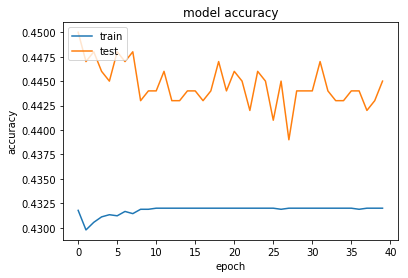

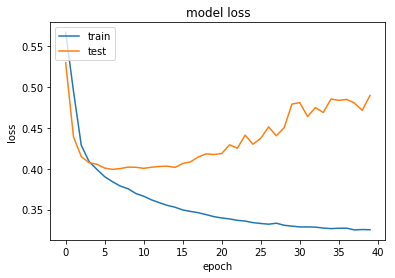

In [205]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [212]:
sentences = [
    "Horrible, this is a bad place. Disgusting",
    "I recommed to all to have a dinner here!"
]

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding='post')

result = model.predict(padded)

print(result)
for i in result:
    print(round(i*5))

[[0.27221116]
 [0.737674  ]]
1.0
4.0
